# 2. Confirming the scenario follows the Poisson process

In [1]:
from scipy.stats import poisson, expon, norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from math import sqrt

In [2]:
# load the dataset
df = pd.read_csv("email_log.csv")

## Prepare the dataset

The date needs to be wrangled so we can answer the questions.

In [3]:
# preview the dataframe
df.head()

,DATE,TIME
0,2020-01-01,09:02:02
1,2020-01-01,09:06:14
2,2020-01-01,09:06:43
3,2020-01-01,09:09:05
4,2020-01-01,09:15:24


### Recasting the dataypyes

The **DATE** and **TIME** attributes have come through as `objects`.
Let us recast them to `datetime64`.

In [4]:
# convert the DATE and TIME to DATETIME
df["DATE"] = pd.to_datetime(df["DATE"])
df["TIME"] = pd.to_datetime(df["TIME"])

### Parsing the DATE and TIME

The Poisson process works in continuous time.
Howver, there are gaps in the data (between 5pm and 9am).
Let us reindex the DATE and TIME fields so we have:

- **DAY**
    - An `integer`, a count from in the days since the origin date.
- **HOUR**
    - An `integer`, the hour the email is received with range $(0, 7)$, so
        - 9am $\to$ 0
        - 10am $\to$ 1
        - $\dots$
- **MINUTE**
    - An `integer`, the minute the email is received.
- **SECOND**
    - An `integer`, the seconds the email is received.

In [5]:
# set the origin data
START_DAY = pd.to_datetime("2020-01-01")

In [6]:
# subtract the origin from the current date
df["DAY"] = df["DATE"] - pd.to_datetime("2020-01-01")

In [7]:
df.dtypes

DATE     datetime64[ns]
TIME     datetime64[ns]
DAY     timedelta64[ns]
dtype: object

**DAY** is now of dtype `timedelta`.
Recast in to `int64` so we can manipulate it for calculations.

In [8]:
df["DAY"] = df["DAY"].dt.days.astype('int64')

In [9]:
# get TIME.hour of TIME as int
df["HOUR"] = df["TIME"].dt.hour.astype('int64')

In [10]:
# reindex 9.00-17.00 to 00.00-08.00
df["HOUR"] = (df["HOUR"] - 1) % 8

In [11]:
# recast TIME.minute to int
df["MINUTE"] = df["TIME"].dt.minute.astype('int64')

In [12]:
# recast TIME.second to int
df["SECOND"] = df["TIME"].dt.second.astype('int64')

In [13]:
# preview the new dataframe
df.head()

,DATE,TIME,DAY,HOUR,MINUTE,SECOND
0,2020-01-01,2020-12-21 09:02:02,0,0,2,2
1,2020-01-01,2020-12-21 09:06:14,0,0,6,14
2,2020-01-01,2020-12-21 09:06:43,0,0,6,43
3,2020-01-01,2020-12-21 09:09:05,0,0,9,5
4,2020-01-01,2020-12-21 09:15:24,0,0,15,24


**TIME** is set to today's date due to the way `pandas` handles `datetimes`.
This is safe to ignore.
The data is now ready.

## Checking the Poisson process

### Is the distribution on number of emails per hour similar to the Poisson distribution?

Let $X$ be a random variable that models the number of emails received, with range $0, 1, 2, \ldots$.
We would expect this to be similar to the Poisson p.m.f.

Let us aggregate a dataframe so it has the following attributes.

- $X$: The number of emails received in an hours.
- $f$: The frequency of $X$.

We will first need to aggregate the data so we have a dataframe showing the number of emails received in a specific hours.
We then count the number of occasions that $X$ appears.

In [14]:
# add a key: dd-hh
df["KEY"] = df["DAY"].astype("str") + "-" + df["HOUR"].astype("str")

In [15]:
# group-by KEY, and count the rows that own the KEY
v_emails_per_hour = df.groupby(by=["KEY"]).count()
v_emails_per_hour.reset_index(inplace=True)

Let us tidy up the DataFrame to make it more legible.
This is optional.

In [16]:
v_emails_per_hour.reset_index(inplace=True)

In [17]:
v_emails_per_hour.drop(columns=["DATE", "TIME", "DAY", "MINUTE", "SECOND"],
                        inplace=True)

In [18]:
v_emails_per_hour.rename(columns={"HOUR": "X"}, inplace=True)

In [19]:
v_emails_per_hour.head()

,index,KEY,X
0,0,0-0,18
1,1,0-1,14
2,2,0-2,18
3,3,0-3,12
4,4,0-4,14


Now let us count us count the frequency of each X.

In [20]:
v_number_of_emails = v_emails_per_hour.groupby(by="X").count()

Let us again tidy up the view.
This is again optional.

In [21]:
v_number_of_emails.drop(columns="index", inplace=True)

In [22]:
v_number_of_emails.reset_index(inplace=True)

In [23]:
v_number_of_emails.rename(columns={"KEY": "f"}, inplace=True)

In [24]:
v_number_of_emails.head()

,X,f
0,3,1
1,4,5
2,5,8
3,6,21
4,7,32


Now let us plot the view of Number of emails per hour.

<AxesSubplot:xlabel='X', ylabel='f'>

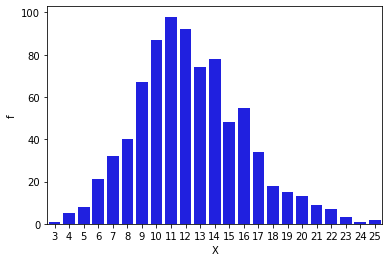

In [25]:
sns.barplot(data=v_number_of_emails,
            x="X",
            y="f",
            color="blue")

Another property of a Poisson distribution is that the $E(X) = V(X)$.
Let us check this is the case for the data.

In [26]:
mean_number = v_emails_per_hour["X"].mean()
mean_number

12.345297029702971

In [27]:
var_number = v_emails_per_hour["X"].var()
var_number

13.604290122320783

ADD CONCLUSION

### Is the rate of emails received is constant?

We need to produce a simple "TIME RECEIVED" against "EVENT" scattergraph.
Let us first get the timestamp (in hours passed since the origin).

In [28]:
v_rate_of_emails = pd.DataFrame()

First we convert each of **DAY**, **MINUTE**, and **SECOND** into unit decimal hours.

In [29]:
# There are 8 hours in a working day.
HOURS_PER_DAY = 8
v_rate_of_emails["DAY (HH)"] = df["DAY"] * HOURS_PER_DAY

In [30]:
v_rate_of_emails["HOUR (HH)"] = df["HOUR"]

In [31]:
# A minute is 1/60 hours
HOURS_PER_MINUTE = 1 / 60
v_rate_of_emails["MINUTE (HH)"] = df["MINUTE"] * HOURS_PER_MINUTE

In [32]:
# A second is 1/3600 hours
HOURS_PER_SECONDS = 1/3600
v_rate_of_emails["SECOND (HH)"] = df["SECOND"] * HOURS_PER_SECONDS

We can now get the time stamp in hours passed since the origin by summing the four new attributes.

In [33]:
v_rate_of_emails["TIME (HH)"] = (v_rate_of_emails["DAY (HH)"] +
                                 v_rate_of_emails["HOUR (HH)"] +
                                 v_rate_of_emails["MINUTE (HH)"] +
                                 v_rate_of_emails["SECOND (HH)"])

Let us add an event label to the view.
This will be the value each point takes measured against the $y-$axis.

In [34]:
# get size of DataFrame
length = v_rate_of_emails["TIME (HH)"].size+1

In [35]:
# create the series
a_range = np.arange(start=1, stop=length)

In [36]:
# append a_range to tmp
v_rate_of_emails["EVENT"] = a_range

Tidy up the view.
This is optional.

In [37]:
v_rate_of_emails.drop(columns=["DAY (HH)",
                               "HOUR (HH)",
                               "MINUTE (HH)",
                               "SECOND (HH)"],
                      inplace=True)

Plot the time series.

<AxesSubplot:xlabel='TIME (HH)', ylabel='EVENT'>

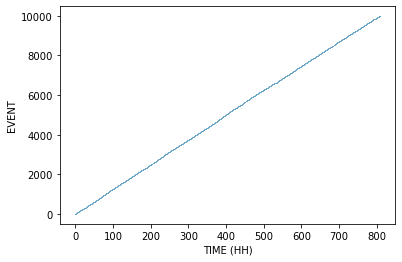

In [38]:
sns.scatterplot(data=v_rate_of_emails,
                x="TIME (HH)",
                y="EVENT",
                alpha=1,
                s=1)

*Conclusion*...

### Is the waiting time between emails similar to the exponential distribution?

Let $W$ be a random variable that represents the time (in hours) between successive emails.
We would expect this to be similar to the exponential p.d.f.

We'll make use of the view from the rate of emails section, introducing a new attribute that measures the time past (in hours) between successive events.

In [39]:
v_waiting_time = pd.DataFrame()

We'll use the `shift()` method to compare successive time stamps.

In [40]:
a_waiting_time = (v_rate_of_emails["TIME (HH)"] -
                  v_rate_of_emails["TIME (HH)"].shift(1))

The first entry will be a `NaN` value, as there is nothing to compare it with.
Let us drop `NaN` values.

In [41]:
a_waiting_time.dropna(inplace=True)

Let us plot a histogram of the waiting times.

<AxesSubplot:xlabel='TIME (HH)', ylabel='Probability'>

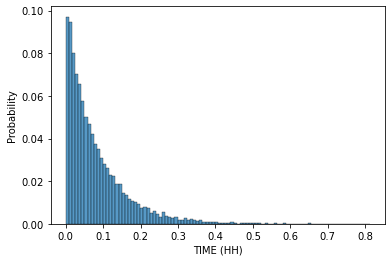

In [42]:
sns.histplot(data=a_waiting_time, stat="probability")

Another property of a Exponential distribution is that the $E(X) = S(X)$.
Let us check this is the case for the data.

In [43]:
mean_waiting = a_waiting_time.mean()
mean_waiting

0.08097344763050597

In [44]:
std = a_waiting_time.std()
std

0.0816630944582385

ADD CONCLUSION.

## Estimating the rate $\lambda$

The maximumum likelihood estimator for the Poisson parameter $\widehat \theta_{f}$ is

$$
\widehat \theta_{f} = \overline X,
$$

and the MLE for the exponential parameter $\widehat \theta_{w}$ is

$$
\widehat \theta_{w} = \frac{1}{\overline X}.
$$

They should be approximately the same.
We have two ways to estimate it here: The number of emails per hour, and the waiting time between emails.
Let us calculate it using both datasets.

### Using the Number of emails per hours

We have already calculated the expected number of emails per hour.

In [45]:
mean_number

12.345297029702971

Therefore, we propose that $\widehat \theta_{f}$ is approximately 13.6.

In [46]:
rate_number = mean_number

### Using the Waiting time between emails

We have already calculated the expected waiting time between emails.

In [47]:
mean_waiting

0.08097344763050597

Therefore, we propose that $\widehat \theta_{w}$ is approximately...

In [48]:
rate_waiting = 1 / mean_waiting
rate_waiting

12.34972733979601

### Conclusion for the esitimation of $\widehat \lambda$

Therefore in conclusion, we propose that the $\widehat \lambda$ is approximately 13.6, given that

$$
\widehat \theta_{f} \simeq \widehat \theta_{w}.
$$